# Défi INSA Toulouse 2019

## Bibliographie

Application of Once Class SVM to detect anomaly : https://www.kaggle.com/amarnayak/once-class-svm-to-detect-anomaly/data

Code qui compare une SVM sur R et Python : http://eric.univ-lyon2.fr/~ricco/tanagra/fichiers/fr_Tanagra_SVM_R_Python.pdf

Site pour comprendre ce qu'est une One-Class SVM : http://rvlasveld.github.io/blog/2013/07/12/introduction-to-one-class-support-vector-machines/

Fonction sur python de la fonction OneClassSVM (fonction équivalente à la section du site au-dessus de la One-Class SVM selon Schölkopf): https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html

Exemple utilisant la fonction One-class SVM : https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#sphx-glr-auto-examples-svm-plot-oneclass-py

## Traitement des données

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.cluster import KMeans

In [2]:
data_train = pd.read_hdf('train.hdf5')

Les données sont composées de séquences d'une minute de mesure d'accéléromètre à une fréquence de 1024 Herts.

60 * 1024 = 61440 variables/colonnes

Training Data : Le jeux de données d'apprentissage est composé de 1677 séquences.

Toutes ces séquences sont considérées comme des séquences normales.

Elles doivent être utilisées pour apprendre le comportement normal des accéléromètres.

In [3]:
data_valid = pd.read_hdf('validation.hdf5')

Validation Data : Le jeu de données de validation est composé de 594 séquences.
    
Les localisations et les angles peuvent, ou pas, être différentes de celles du jeu de données d'apprentissage. 

Un taux inconnu de ces séquences présentens un comportement anormal. 

Ces séquences doivent être détectées en les comparant aux séquences normales du jeu de données d'apprentissage.

In [5]:
data_train.head()

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,0.041259,0.041259,0.032573,0.023887,0.029315,0.041259,0.045602,0.038001,0.030401,0.032573,...,0.034744,-0.007600,-0.003257,0.065145,0.047773,-0.009772,0.031487,0.096632,0.077089,0.040173
1,-0.211722,-0.264924,-0.274696,-0.236694,-0.156349,-0.059716,0.005429,0.046687,0.153091,0.281210,...,0.260581,-0.004343,-0.241037,-0.636252,-0.953292,-0.980436,-0.846888,-0.838202,-0.880546,-0.739398
2,0.214105,0.154930,0.136640,0.013987,-0.038733,-0.015063,-0.111894,-0.104363,0.047340,-0.054871,...,0.040884,0.375490,0.699337,0.965085,1.086662,1.132926,1.279249,1.296464,0.937112,0.451879
3,-0.154837,-0.127768,-0.217638,-0.284770,-0.299929,-0.270694,-0.077960,0.092036,0.076877,0.154837,...,-0.286936,-0.171079,-0.036814,-0.024904,0.031400,0.140761,-0.011911,-0.173244,-0.063884,0.081208
4,-1.022780,-0.916376,-0.676425,-0.461445,-0.330069,-0.122690,0.178064,0.489675,0.799115,0.931577,...,1.009751,1.134613,0.836030,0.479903,0.109661,-0.285553,-0.628651,-0.916376,-1.010837,-0.804544


In [6]:
data_valid.head()

,0,1,2,3,4,5,6,7,8,9,...,61430,61431,61432,61433,61434,61435,61436,61437,61438,61439
0,0.070650,0.085524,0.076847,0.085524,0.120229,0.140061,0.107834,0.048340,0.014874,0.030987,...,0.018592,-0.017353,-0.049579,-0.061974,-0.022311,0.052058,0.091721,0.075608,0.045861,0.027268
1,-0.300685,-0.882656,-1.733789,-2.181179,-1.942328,-1.719240,-1.981126,-2.323034,-2.325459,-2.349708,...,0.454665,-0.782024,-1.725302,-1.829572,-1.170004,-0.278861,-0.152767,-1.035424,-2.312123,-3.199628
2,-0.056398,-0.152028,-0.058850,0.140994,0.170419,0.154480,0.270954,0.359228,0.334708,0.349420,...,0.023295,-0.019617,-0.062528,-0.094405,-0.105439,-0.123830,-0.166741,-0.159385,-0.106665,-0.131186
3,0.030618,0.020412,0.058747,0.124712,0.155828,0.161553,0.167777,0.170515,0.165038,0.141141,...,-0.073682,-0.052524,-0.023897,-0.009210,0.016429,0.058000,0.097828,0.114755,0.090360,0.054764
4,-1.071597,-6.912540,-13.677612,-16.463519,-15.790084,-11.653620,-7.668311,-9.942997,-14.321553,-13.704648,...,-5.227723,-6.107613,-6.577051,-6.123589,-5.324806,-4.965969,-4.464579,-3.442138,-3.794831,-6.133420


Interprétation du nu:
    
Le paramètre nu correspond à une limite supérieur de vecteurs supports, et une limite inférieure de points d'entrainements mal classées/en dehors de la marge estimée (par exemple, si nu=0.05, alors on est assuré de trouver au plus 5% de nos points d'entrainement mal classées au prix d'une petite marge, mais au moins 5% des points d'entrainements qui seront des vecteurs supports).
L'augmentation du paramètre "nu" entraîne un sous-ajustement et une petite valeur pour "nu" provoque un surajustement.

Interprétation de gamma:
    
Une valeur de gamma faible signifie que le modèle est moins enclin au sur-ajustement => cela conduit à un biais élevé, et une variance faible du modèle.
Une valeur de gamma forte signifie que le modèle sur-ajuste => cela conduit à un biais faible et une variance élevée du modèle.

# Optimisation paramètres de la SVM One Class

On va tenter de regarder si on gagne du temps en pré-calculant la matrice de gram.

In [ ]:
# https://stackoverflow.com/questions/26962159/how-to-use-a-custom-svm-kernel

# Exemple trouvé sur internet
import numpy as np

from sklearn import svm


def gaussianKernelGramMatrixFull(X1, X2, sigma=0.1):
    """(Pre)calculates Gram Matrix K"""

    gram_matrix = np.zeros((X1.shape[0], X2.shape[0]))
    for i, x1 in enumerate(X1):
        for j, x2 in enumerate(X2):
            x1 = x1.flatten()
            x2 = x2.flatten()
            gram_matrix[i, j] = np.exp(- np.sum( np.power((x1 - x2),2) ) / float( 2*(sigma**2) ) )
    return gram_matrix

X=...
y=...
Xval=...

C=0.1
clf = svm.SVC(C = C, kernel="precomputed")
model = clf.fit( gaussianKernelGramMatrixFull(X,X), y )

p = model.predict( gaussianKernelGramMatrixFull(Xval, X) )

## Regardons le temps de calcul pour une one-class SVM en lui fournissant :
- une matrice de Gram pré-calculée en utilisant le noyau "precomputed", qui a pour formule : K(xi, xj) = exp ( - gamma * d(xi, xj)^2 )
- le paramètre "rbf"

### Avec la matrice de Gram pré-calculée

In [15]:
import time
start_time = time.time()

from scipy.spatial.distance import cdist

value_gamma=0.00001
SVM_oneclass_kernelPrecomputed = svm.OneClassSVM(kernel='precomputed', gamma=value_gamma, nu=0.5)
# rbf kernel computation
gram = np.exp(-value_gamma*cdist(data_train, data_train, 'euclidean')**2)
SVM_oneclass_kernelPrecomputed.fit(gram) 
from scipy.spatial.distance import cdist

# predict on training examples
gram_valid = np.exp(-value_gamma*cdist(data_valid, data_train, 'euclidean')**2)
pred_anomaly = SVM_oneclass_kernelPrecomputed.predict(gram_valid)


print("--- %s seconds ---" % (time.time() - start_time))
from collections import Counter
Counter(pred_anomaly)

--- 273.27357721328735 seconds ---


Counter({1: 251, -1: 343})

### Avec la paramètre 'rbf'

In [16]:
import time
start_time = time.time()

kernel = 'rbf'
gamma = 0.00001
nu = 0.5
SVM_oneclass = svm.OneClassSVM(kernel=kernel, gamma=gamma, nu=nu)
SVM_oneclass.fit(data_train) 
pred_anomaly = SVM_oneclass.predict(data_valid)

print("--- %s seconds ---" % (time.time() - start_time))
from collections import Counter
Counter(pred_anomaly)

--- 192.33393740653992 seconds ---


Counter({1: 251, -1: 343})

Le temps de calcul en lui fournissant une matrice de gram pré-calculée, prend plus de temps. Faisons alors directement avec le paramètre 'rbf'.

## Algortihme de prédiction : SVM One-Class

Sur le site https://defi-ia.insa-toulouse.fr/account, on a une colonne Recall (=Rappel), qui est de la forme $R=\frac{TP}{TP+NP}$

TP : True Positive : c'est le nombre d'anomalies qu'on a bien détectés. 

NP : nombre d'anomalies non détectés.

TP+NP : c'est le nombre d'anomalies totale dans notre jeu de validation.

La meilleure équipe dans le classement pour le défi à un rappel de 0.996632996633.

Imaginons qu'il lui manque une anomalie qui n'a pas été détecté.

Ainsi, on essaye de trouve le nombre de True Positive : $R=\frac{TP}{TP+1}=0.99663299633$

On obtient TP qui est environ égale à 272.

On va essayer de trouver un nombre d'anomalies, -1, proche de 272 en changeant les paramètres : 
- nu 
- gammma


### Paramètre nu

In [19]:
tb_count_moins1 = pd.DataFrame(index = ['Count outliers'])
tb_count_1 = pd.DataFrame(index = ['Count inliers'])

seq_nu = [0.3, 0.35, 0.4, 0.5]
for nu_i in seq_nu:
    tb_pred = pd.DataFrame()
    SVM_oneclass = svm.OneClassSVM(kernel="rbf", gamma=0.00001, nu=nu_i)
    SVM_oneclass.fit(data_train) 
    pred_anomaly = SVM_oneclass.predict(data_valid)
    
    tb_count_1[nu_i] = [int(Counter(pred_anomaly)[1])]
    tb_count_moins1[nu_i] = [int(Counter(pred_anomaly)[-1])]
    
tb_count_nu = pd.concat([tb_count_1, tb_count_moins1])
tb_count_nu

,0.30,0.35,0.40,0.50
Count inliers,335,315,298,251
Count outliers,259,279,296,343


Le nombre d'outliers se rapproche de 272 avec nu=0.35.

## Paramètre gamma

In [20]:
tb_count_moins1 = pd.DataFrame(index = ['Count outliers'])
tb_count_1 = pd.DataFrame(index = ['Count inliers'])

seq_gamma = [0.001, 0.0005, 0.0001, 0.00005, 0.00001]
for gamma_i in seq_gamma:
    tb_pred = pd.DataFrame()
    SVM_oneclass = svm.OneClassSVM(kernel="rbf", gamma=gamma_i, nu=0.35)
    SVM_oneclass.fit(data_train) 
    pred_anomaly = SVM_oneclass.predict(data_valid)
    
    tb_count_1[gamma_i] = [int(Counter(pred_anomaly)[1])]
    tb_count_moins1[gamma_i] = [int(Counter(pred_anomaly)[-1])]
    
tb_count_gamma = pd.concat([tb_count_1, tb_count_moins1])
tb_count_gamma

,0.00100,0.00050,0.00010,0.00005,0.00001
Count inliers,116,167,279,312,315
Count outliers,478,427,315,282,279


Le nombre d'outliers se rapproche de 272 avec gamma=0.00001

## Faisons varier maintenant nu entre 0.30 et 0.35

In [28]:
tb_count_moins1 = pd.DataFrame(index = ['Count outliers'])
tb_count_1 = pd.DataFrame(index = ['Count inliers'])

seq_nu = [0.31, 0.32, 0.33,0.34, 0.35]
for nu_i in seq_nu:
    tb_pred = pd.DataFrame()
    SVM_oneclass = svm.OneClassSVM(kernel="rbf", gamma=0.00001, nu=nu_i)
    SVM_oneclass.fit(data_train) 
    pred_anomaly = SVM_oneclass.predict(data_valid)
    
    tb_count_1[nu_i] = [int(Counter(pred_anomaly)[1])]
    tb_count_moins1[nu_i] = [int(Counter(pred_anomaly)[-1])]
    
tb_count_nu = pd.concat([tb_count_1, tb_count_moins1])
tb_count_nu

,0.31,0.32,0.33,0.34,0.35
Count inliers,330,327,320,318,315
Count outliers,264,267,274,276,279


On choisit donc de garder les paramètre gamma=0.00001 et nu=0.33.

In [31]:
SVM_oneclass = svm.OneClassSVM(kernel="rbf", gamma=0.00001, nu=0.33)
SVM_oneclass.fit(data_train) 
pred_anomaly = SVM_oneclass.predict(data_valid)
Counter(pred_anomaly)

Counter({1: 320, -1: 274})

In [32]:
pred_anomaly2 = pd.DataFrame(pred_anomaly)

In [33]:
pred_anomaly2 = pred_anomaly2.replace(1, 0)
pred_anomaly2 = pred_anomaly2.replace(-1, 1)

In [34]:
data = {'seqID': np.arange(0,len(data_valid)), 'anomaly': pred_anomaly2[0]}
y_test_template = pd.DataFrame(data)

In [35]:
y_test_template

,seqID,anomaly
0,0,0
1,1,1
2,2,0
3,3,0
4,4,1
...,...,...
589,589,1
590,590,1
591,591,0
592,592,0


On s'assure que les données sont bien des entiers

In [36]:
y_test_template["seqID"] = y_test_template["seqID"].astype(int)

In [37]:
y_test_template["anomaly"] = y_test_template["anomaly"].astype(int)

### Exportation du fichier sous .csv

In [38]:
y_test_template.to_csv('y_test_template_soumission_6.csv',  index = False, sep=";")

Le F1 Score est de: 0.86865 avec cette méthode et ces hyperparamètres.

Precision: 0.90511

Recall: 0.83502

## Isolation Forest

Idée principale derrière l'algorithme isolation forest : L'algorithme isole chaque point et sépare les points en outliers et inliers. L'algorithme identifie les outliers en fonction du temps/chemin pour isoler le point. Plus l'algorithme mettra de temps à isoler un point plus la probabilité d'un point étant outlier diminue. Un point facile à isoler sera donc nécessairement un outlier.

Cet algorithme est particulièrement efficace en grande dimension. Ce qui est intéressant ici c'est qu'on peut rentrer un paramètre de contamination aka le pourcentage d'outlier dans notre data set.

Hyperparamètres : 
- n_estimators : nombres d'arbres de décision dans la forêt (en général 100 ok)
- max_samples : nombre d'échantillons à tirer de X pour former chaque estimateur (auto?)
- max_features : nombre de variables à tirer de X pour former chaque estimateur
- contamination : proportion d'outliers (0?)

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn import model_selection
from sklearn.metrics import f1_score, make_scorer
from collections import Counter

Testons dans un premier temps l'algorithme en laissant nos hyperparamètres par défaut

In [ ]:
clf = IsolationForest(contamination = 'auto', behaviour = 'new', random_state = np.random.RandomState(42), n_jobs = -1)
model = clf.fit(data_train)

In [ ]:
predictions = model.predict(data_valid)

In [ ]:
Counter(predictions)

On a donc obtenu un score de 0.82 en f1-score, 1 en précision et 0.70 en recall (plutôt intéressant!)

On peut ainsi chercher à ajuster au mieux nos paramètres pour améliorer l'algorithme et se rapprocher de 300 outliers par validation croisée

In [5]:
max_features = [0.1, 0.25, 0.5, 0.75, 1]
tb_count_moins1 = pd.DataFrame(index = ['Count outliers'])
tb_count_1 = pd.DataFrame(index = ['Count inliers'])
contamination = [0.1, 0.2, 0.3, 0.4, 0.5]

for i in max_features:
    for j in contamination:
        tb_pred = pd.DataFrame()
        clf = IsolationForest(contamination = j, behaviour = 'new', random_state = np.random.RandomState(42), max_features = i, n_jobs = -1)
        clf.fit(data_train) 
        pred_anomaly = clf.predict(data_valid)
        
        tb_count_1[i,j] = [int(Counter(pred_anomaly)[1])]
        tb_count_moins1[i,j] = [int(Counter(pred_anomaly)[-1])]
    
tb_count_nu = pd.concat([tb_count_1, tb_count_moins1])
tb_count_nu

,"(0.1, 0.1)","(0.1, 0.2)","(0.1, 0.3)","(0.1, 0.4)","(0.1, 0.5)","(0.25, 0.1)","(0.25, 0.2)","(0.25, 0.3)","(0.25, 0.4)","(0.25, 0.5)",...,"(0.75, 0.1)","(0.75, 0.2)","(0.75, 0.3)","(0.75, 0.4)","(0.75, 0.5)","(1, 0.1)","(1, 0.2)","(1, 0.3)","(1, 0.4)","(1, 0.5)"
Count inliers,375,347,323,292,251,378,348,330,297,262,...,375,358,333,301,264,370,350,329,292,257
Count outliers,219,247,271,302,343,216,246,264,297,332,...,219,236,261,293,330,224,244,265,302,337


Testons un submit avec pour paramètre de contamination 0.4 et de max_features = 0.25

In [8]:
clf = IsolationForest(contamination = 0.4, max_features = 0.25, behaviour = 'new', random_state = np.random.RandomState(42), n_jobs = -1)
model = clf.fit(data_train)

In [9]:
predictions = model.predict(data_valid)
Counter(predictions)

Counter({1: 297, -1: 297})

In [10]:
pred_anomaly2 = pd.DataFrame(pred_anomaly)
pred_anomaly2 = pred_anomaly2.replace(1, 0)
pred_anomaly2 = pred_anomaly2.replace(-1, 1)
data = {'seqID': np.arange(0,len(data_valid)), 'anomaly': pred_anomaly2[0]}
y_test_template = pd.DataFrame(data)

In [11]:
y_test_template

,seqID,anomaly
0,0,0
1,1,1
2,2,0
3,3,0
4,4,1
5,5,1
6,6,0
7,7,1
8,8,1
9,9,0


In [12]:
y_test_template.to_csv('y_test_template_soumission_7.csv',  index = False, sep=";")

Sauvegardons notre tableau pour avoir à éviter de relance notre algorithme la prochaine fois

In [13]:
tb_count_nu.to_pickle('tb_count.pkl')

## Clustering-Based Anomaly Detection : DBSCAN, K-Means

L'algorithme des K-Means est un algorithme de classification largement utilisé dans ce domaine. Il crée «k» des groupes similaires de points de données. Les instances de données qui ne font pas partie de ces groupes peuvent potentiellement être marquées comme des anomalies.

Contrairement aux k-means, l'algorithme de DBSCAN (density-based spatial clustering of applications with noise) ne nécéssite pas qu'on lui précise le nombre de clusters. 

L'algorithme DBSCAN prends en compte deux paramètres, la distance epsilon et le nombre de points minimum devant se trouver dans un rayon epsilon. L'idée est de prendre un point et récupérer les points voisins dans un rayon epsilon et de vérifier qu'il contient bien le nombre de points minimum fixé. Ainsi il permet d'identifier les données abérantes qui ne vérifient pas le nombre de voisins min.

**K-Means**

In [20]:
data = pd.concat([data_train, data_valid])

In [23]:
inertia = []
for i in range(1,10):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

MemoryError: 

In [ ]:
plt.plot(range(1, 10), inertia)
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie intra classes') #within cluster sum of squares
plt.show()

In [ ]:
kmeans = KMeans(n_clusters = 3)
model = kmeans.fit(data)

In [ ]:
def dist_centroide(data, model):
    distance = pd.Series()
    nbcluster = model.labels_.max()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        dist = []
        for j in range(0, nbcluster):
            if model.labels_[i] != j:
                Xb = model.cluster_centers_[j]
                dist.append(np.linalg.norm(Xa-Xb))
        distance.set_value(i, min(dist))
    return distance

In [ ]:
distance = dist_centroide(data, model)
nb_outliers = 300
seuil = distance.nlargest(nb_outliers).min()
data_valid['anomaly'] = (distance >= seuil).astype(int)

**DBSCAN**

In [25]:
minPts = int(np.log(len(data)))

In [26]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=minPts)
nbrs = neigh.fit(data)
distances, indices = nbrs.kneighbors(data)

On trie nos distances et on trace l'évolution de nos distances. On prendra epsilon optimal au changement de valeur le plus prononcé.

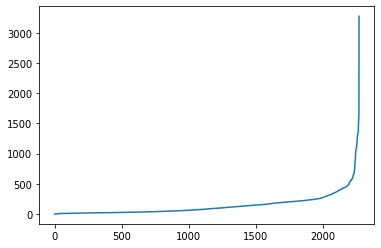

In [27]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [29]:
from sklearn.cluster import DBSCAN
outliers = DBSCAN(eps = 200, metric = "euclidean", n_jobs = -1, min_samples = minPts)
clf = outliers.fit(data)

In [30]:
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [31]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 585
